In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


***IMPORT ALL LIBRARIES***

In [2]:
import csv
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.utils import shuffle
import nltk
from nltk.tokenize import word_tokenize
from random import shuffle
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import string
import math
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***UNIVERSAL VARIABLE DECLARATION***

In [0]:
#universal variable decleration
dataset=[]
trainData=[]
testData=[]
trainData_label=[]
testData_label=[]
num_messages = {}
log_class_priors = {}
word_counts = {}
vocab = set()
table = str.maketrans({key: None for key in string.punctuation})  # This  variable is used fro translation of text so that punctuations are replaced with none 
label=[]
data=[]
word_counts['REAL'] = {}
word_counts['FAKE'] = {}
cv_result=[]

***DEFINE PATH &***
***CLEAN DATASET***

In [0]:


path=r"/content/drive/My Drive/Colab Notebooks/amazon_dataset_final.csv"
df=pd.read_csv(path,encoding='cp1252')
df=df.sample(frac=1).reset_index(drop = True)
df=df.replace({'LABEL':{'__label1__':'FAKE','__label2__':'REAL'}})
label=df['LABEL'].tolist()
df2=df
df2 = df2.drop("LABEL", axis=1)
r,c=df2.shape
#df2.head()




***VISUALIZATION OF DATASET***

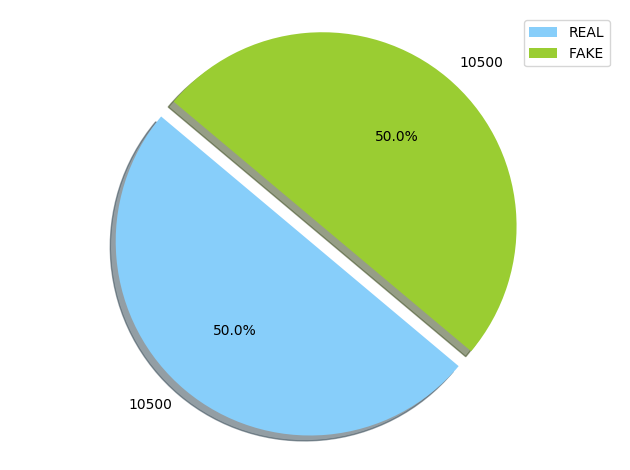

In [5]:
count_real=0
count_fake=0
for x in label:
  if x == 'REAL':
    count_real +=1
  else:
    count_fake +=1

count_rf=[count_real,count_fake] 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real,count_fake

colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()

***WORD CLOUD CREATION***

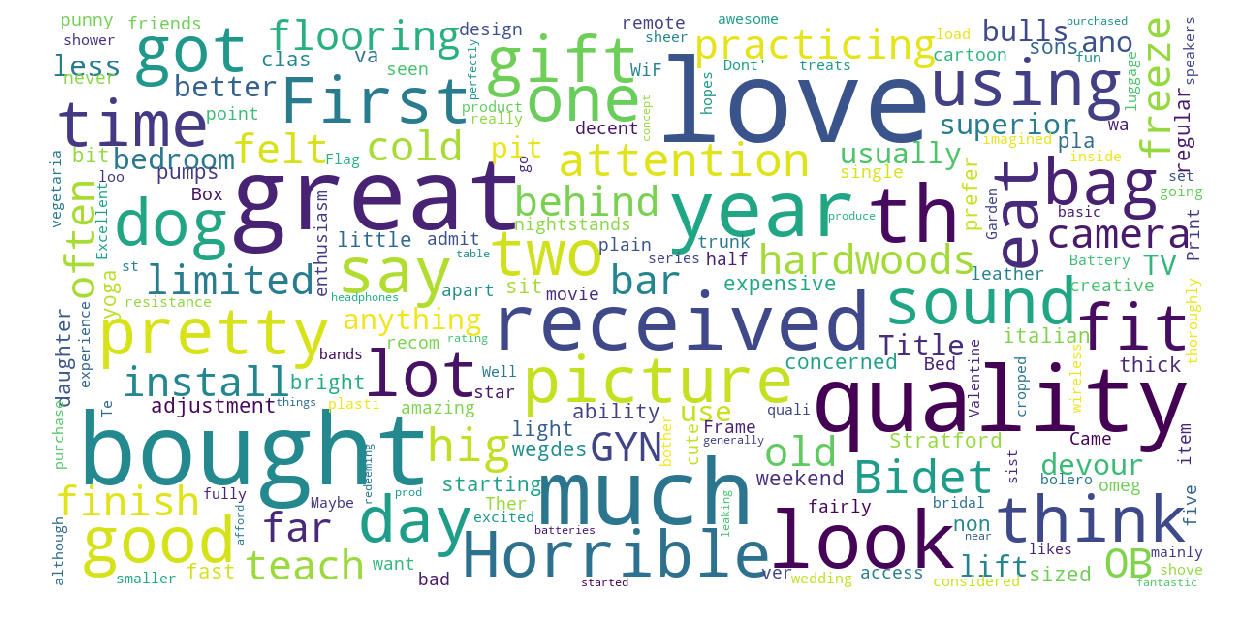

In [29]:
# word cloud Creation
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data1, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data1))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['REVIEW_TEXT'])

***PARSE FUNCTION TO PARSE DATASET AND TAKE IMPORTANT FEATURES FROM IT***

In [0]:
def parse(review):
 
    return (review[1],review[2],review[3],review[6],review[7])


***TEXT PREPROCESSING FUNCTION***




*    STOP WORD REMOVAL

*   PUNCTUATIONS REMOVAL
*  LEMMATIZATION


*  nltk BIGRAM / UNIGRAM CFREATION







In [0]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION
# Input: a string of one review
# t={key: None for key in string.punctuation} #It will return none for puntuations


def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table) # translation of text is done here punctuations are replaced with none
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens #nltk bigrams will make pair of word occur together mrore frequently
        #here ' '.join(l) means it will join the words from the list (here it is l of iterable) with ' ' delimeter in between. 
    return filtered_tokens #lemmatized_tokens  #filtered_tokens
    
    

***WORD COUNT FUNCTION***



*   IT RETURNS COUNT OF WORDS IN A  PARTICULAR REVIEW 






In [0]:
def get_word_counts(x1):
  word_count = {}
  for word in x1:
    word_count[word] = word_count.get(word, 0.0) + 1.0
  return word_count

**LOG_CLASS_PRIOR FUNCTION  TO CLACULATE LOG PRIORITY OF THE PARTICULAR CLASS**

In [0]:
#calculate log proior of real and fake
def LOG_CLASS_PRIOR(trainData_label1):
  n=len(trainData_label1)
  num_messages1={}
  log_class_priors1={}
  
  num_messages1['REAL'] = sum(1 for l in trainData_label1 if l == 'REAL')
  num_messages1['FAKE'] = sum(1 for l in trainData_label1 if l == 'FAKE')

  log_class_priors1['REAL'] = math.log(num_messages1['REAL'] / n)
  log_class_priors1['FAKE'] = math.log(num_messages1['FAKE'] / n)
  
  return num_messages1,log_class_priors1
  

***TRAIN CLASSIFIER  TO TRAIN MODEL***



*    THIS FUNCTION TAKES THE DATASET AND LABEL AS INPUT AND THEN ZIP IT  ALONG AXIS =1, THEN COUNT NO OF WORDS IN EACH REVIEW TUPLE  THEN ADD IT TO THE GLOBAL VOCABULARY AND ALSO INTO THE DICTIONARY OF RESPECTIVE CLASS, AND THEN RETURN WORD_COUNT DICTIONARY 






In [0]:
def trainClassifier(dataset2,label2):
 
  for x, y in zip(dataset2, label2):
    counts = get_word_counts(x)
    for word1, count1 in counts.items():
      if word1 not in vocab:
        vocab.add(word1)
        
      if word1 not in word_counts[y]:
        word_counts[y][word1] = 0.0
         
      word_counts[y][word1] += count1
      
      
  return word_counts
  
  

***PREDICT FUNCTION IS FOR PREDICTION OF RESULT AFTER TRAING HAS BEEN DONE BY THE CLASSIFIER  ***





*   IT TAKES TESTDATA_SET , CLASSIFIER OUTPUT, LOGCLASS_PRIOR AND NUM_MESSAGE (DICTIONARY) AS INPUT
*   IT THEN CLACULATES THE LOG PROBABILITY OF EACH WORD IN EACH TUPLE OF TEST DATA, W.R.P.T EACH LABEL(CLASS) , AND ASSIGN LABEL TO THAT REVIEW DATA THE CLASS LABEL WITH THE HIGHEST LOG PROBABILITY






In [0]:
def predict(testData1,classifier1,log_class_priors2,num_messages2):
    result = []
    for x in testData1:
        counts1 = get_word_counts(x)
        REAL_score = 0
        FAKE_score = 0
        for word2, _ in counts1.items():
            if word2 not in vocab: continue
            
            # add Laplace smoothing
            log_w_given_FAKE = math.log( (classifier1['FAKE'].get(word2, 0.0) + 1) / (num_messages2['FAKE'] + len(vocab)) )
            log_w_given_REAL = math.log( (classifier1['REAL'].get(word2, 0.0) + 1) / (num_messages2['REAL'] + len(vocab)) )
 
            FAKE_score = FAKE_score+log_w_given_FAKE
            REAL_score = REAL_score+log_w_given_REAL
 
        FAKE_score = FAKE_score+ log_class_priors2['FAKE']
        REAL_score = REAL_score+ log_class_priors2['REAL']
 
        if FAKE_score > REAL_score:
            result.append('FAKE')
        else:
            result.append('REAL')
    return result

  

***ACUURACY FUNCTION TO CLCULATE ACCURACY OF THE CLASSIFIER***

 
*   HERE THE ACCURACY IS CALCULATED BY COMPARING OUTPUT OF THE PREDICTION FUNCTION WITH THE TEST LABEL DATA 







In [0]:
# Accuracy prdiction
def Accuracy(true,pred):
  accuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i]) / float(len(pred))
  #print("{0:.4f}".format(accuracy))
  return accuracy


***PRECISION FUNCTION ***



*   IT COMPUTE THE PRECISION OF THE CLASSIFIER
*   FORMULA IS  **TP/(TP+FP**)









In [0]:
#precision 
def Precision(true,pred):
  precision=0
  TP=0
  FP=0
  for x,y in zip(true,pred):
    if x==y=='FAKE':
      TP=TP+1
    if x=='REAL'and y=='FAKE':
      FP=FP+1
  #print(TP,FP)
  precision = TP/(TP+FP)

  #print(precision)
  return precision



***RECALL FUNCTION***



*   IT COMPUTE THE RECALL OF THE CLASSIFIER

*   FORMULA IS **TP/(TP+FN)**






In [0]:
#recall
def Recall(true,pred):
  recall=0
  TP=0
  FN=0
  for x,y in zip(true,pred):
    if x==y=='FAKE':
      TP=TP+1
    if x=='FAKE'and y=='REAL':
      FN=FN+1
  #print(TP,FN)
  recall = TP/(TP+FN)
  #print(TP,FN)
  #print(recall)
  return recall


***F1 SCORE FUNCTION***

*   IT CALCULATES F1 SCORE OF THE CLASSIFIER
*   FORMULA IS  **2 x PRECISION x RECALL/ ( PRECISION + RECALL)** 









In [0]:
#F1 score
def F1_SCORE(precision,recall):
  F1_score=0
  F1_score =(precision*recall*2)/(precision+recall)
  #print(F1_score)
  return F1_score


***DATASET CREATION ***
 

*   HERE  I CREATES LIST WHICH CONTAIN ALL THE TUPLES OF DATAFRAME
*   THEN PASS EACH TUPLE TO PARSE FUNCTION THEN SOTRE THE RETURN VALVE IN NEW LIST







In [0]:
dataset=list(df2.values)
dataset[0]

for i in range(r):
    (rating,vf,product_category,review_title,Text) = parse(dataset[i])
    data.append((rating,vf,product_category,review_title,Text))


#data[0]

***SPLIT FUNCTION TO SPLIT TYHE DATASET INTO TRAIN AND TEST DATASET***

In [0]:
def split(percent):
    dataSamples = len(data)
    halfOfData = int(len(data)/2)
    trainingSamples = int((percent*dataSamples)/2)
    
    for (rating,vf,product_category,review_title,Text) in data[:trainingSamples] + data[halfOfData:halfOfData+trainingSamples]:
      trainData.append((preprocess(f'{rating} {vf} {product_category} {review_title+Text}')))
    
    for x in label[:trainingSamples]+label[halfOfData:halfOfData+trainingSamples]:
      trainData_label.append(x)
    
    for (rating,vf,product_category,review_title,Text) in data[trainingSamples:halfOfData] + data[halfOfData+trainingSamples:]:
      testData.append((preprocess(f'{rating} {vf} {product_category} {review_title+Text}')))
     
    for x in label[trainingSamples:halfOfData]+label[halfOfData+trainingSamples:]:
      testData_label.append(x)
    

***CROSS VALIDATION  FUNCTION***



*  IT CROSS VALIDATED THE CLASSIFIER RESULT  IN FOLD OF 10








In [0]:
    def crossValidate(dataset1,label1,folds):
      cv_res=[]
      foldSize = int(len(dataset1)/folds)
      for i in range(0,len(dataset1),foldSize):
        classifier = trainClassifier(dataset1[:i]+dataset1[foldSize+i:],label1[:i]+label1[foldSize+i:])
        num_messages3,log_class_prior3=LOG_CLASS_PRIOR(label1[:i]+label1[foldSize+i:])
        y_pred = predict(dataset1[i:i+foldSize],classifier,log_class_prior3,num_messages3)
        true=label1[i:i+foldSize]
        a = Accuracy(true,y_pred)
        p = Precision(true,y_pred)
        r = Recall(true,y_pred)
        f = F1_SCORE(p,r)
        cv_res.append((a,p,r,f))
        cv_result.append((a,p,r,f))
      cv_res = (np.mean(np.array(cv_res),axis=0))
      
      return cv_res

***HERE SPLIT FUNCTION IS CALLED***



*   DATASET IS SPLITED INTO 80:20 RATIO OF TRAINING AND TEST SET





In [0]:
#split dataset into trainig and test data 80:20 ration
split(0.80)

 ***VISUALIZATION OF TRAINING DATASET***


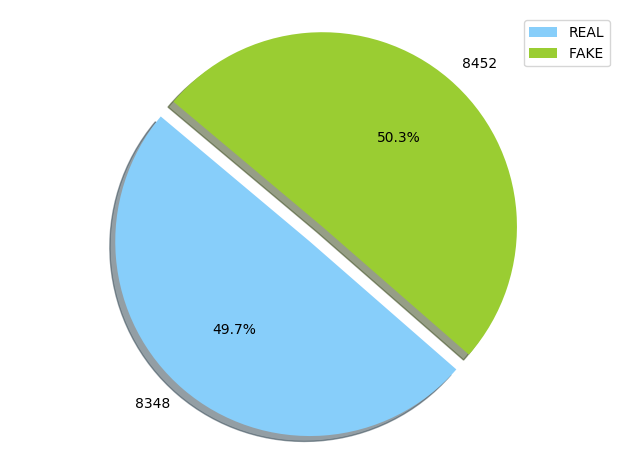

In [20]:
count_real_tr=0
count_fake_tr=0
for x in trainData_label:
  if x == 'REAL':
    count_real_tr +=1
  else:
    count_fake_tr +=1

count_rf_tr=[count_real_tr,count_fake_tr]


 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real_tr,count_fake_tr

colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf_tr, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()

***VISUALIZATION OF TEST DATASET***

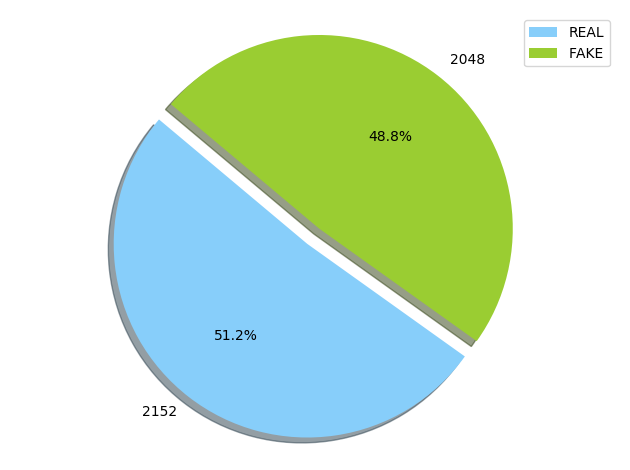

In [21]:
count_real_te=0
count_fake_te=0
for x in testData_label:
  if x == 'REAL':
    count_real_te +=1
  else:
    count_fake_te +=1

count_rf_te=[count_real_te,count_fake_te]


 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real_te,count_fake_te
colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf_te, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()

***HERE CROSS VALIDATATION FUNCTION IS CALLED***






In [0]:
#cross validation result 
CV_RESULT=crossValidate(trainData,trainData_label,10)


***MEAN OF  10 FOLD CROSS VALIDATON RESULT***

In [23]:
print("Mean of cross-validations (Accuracy, Precision, Recall, F1score): ",CV_RESULT )


Mean of cross-validations (Accuracy, Precision, Recall, F1score):  [0.96404762 0.99244186 0.93112162 0.9503605 ]


***VISUALIZATION OF 10 FOLD CROSS VALIDATION RESULT ON TRAINING DATA SET***

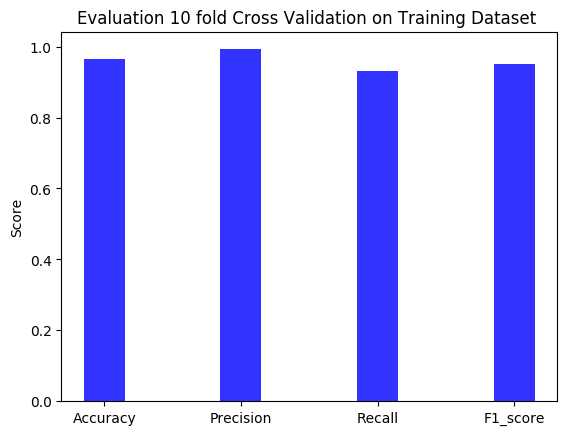

In [24]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = CV_RESULT
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 
plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation 10 fold Cross Validation on Training Dataset ')


plt.show()

***HERE TESTING IS PERFORMED ON TEST SET***

In [25]:
# Testing test data

num_messages,log_class_priors=LOG_CLASS_PRIOR(trainData_label)
pred1=predict(testData,word_counts,log_class_priors,num_messages)
true1= testData_label
acc = Accuracy(true1,pred1)
pre = Precision(true1,pred1)
rec = Recall(true1,pred1)
f1 = F1_SCORE(pre,rec)
Test_result=[acc,pre,rec,f1]
print(acc)
print(pre)
print(rec)
print(f1)


0.6704761904761904
0.8688888888888889
0.3818359375
0.5305291723202171


***VISUALIZATION OF PREDICTION RESULT ON TEST DATA SET***

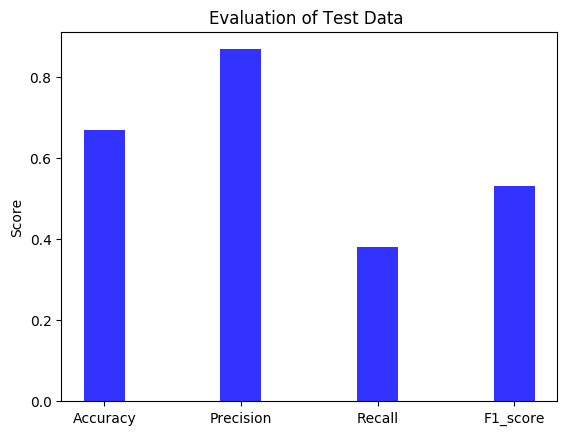

In [26]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = Test_result
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 

plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation of Test Data ')


plt.show()

***10 FOLD  CROSS VALIDATION RESULT ON TESTDATA SET ***

In [27]:
TEST_RESULT=crossValidate(testData,testData_label,10)
print("Mean of cross-validations (Accuracy, Precision, Recall, F1score): ",TEST_RESULT)


Mean of cross-validations (Accuracy, Precision, Recall, F1score):  [0.95119048 0.98317995 0.90901059 0.93405153]


***VISUALIZATION OF 10 FOLD CROSS VALIDATION RESULT ON TEST DATA SET***

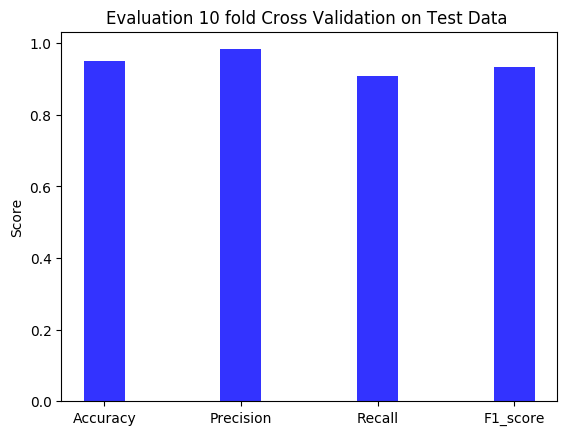

In [28]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = TEST_RESULT
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 

plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation 10 fold Cross Validation on Test Data ')


plt.show()